# Invistico Airlines: Predicting Passenger Satisfaction

## Project Summary

### Objectives

* Train machine learning classifiers to predict whether a passenegr will be satisfied or not based on numerous flight and personal attributes

* Identify the most important features for passenger satisfaction to aid the airlines prioritization of future service improvements.


### Methodology

* Exploratory Data Analysis - discover potentially useful trends betwenn features and assess if any data cleaning required (source dataset was mostly cleaned).

* Machine Learning Model Training - fine-tune hyperparameters of different classifiers (Random Forest and XGBoost) and compare performance of each to one another as well as the baseline model. Since both classifier types in this project apply decision tree classifiers, their respective feature importances can be extracted to identify the most significant service aspectes for passenger satisfaction.


### Key Conclusions

* Both tuned classifiers had very similar performances on the training and test datasets (~ 93% recall and ~ 94% accuracy) and were both significantly superior to the baseline model.

* The three most significant services affecting satisfaction are inflight entertainment, seat comfort, and ease of online booking.


In [17]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
sns.set()

# plotting
from plotting import plot_learning_curve, plot_validation_curve

# initial EDA automated tools
from eda_auto_func import func

# ML/baseline classifiers
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# scikit-learn tools
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix
from skopt import BayesSearchCV

In [18]:
"""Useful functions for later use
"""

def score_output(estimator, train_X, test_X, train_y, test_y):

    # Make predictions on test data
    estimator.fit(train_X, train_y)
    pred = estimator.predict(test_X)
    train = estimator.predict(train_X)

    # Assess performance using metrics
    print('----------\nRecall\n')
    print(f'Test: {recall_score(test_y, pred): .4f}\nTraining: {recall_score(train_y, train): .4f}\n')
    print('----------\nAccuracy\n')
    print(f'Test: {accuracy_score(test_y, pred): .4f}\nTraining: {accuracy_score(train_y, train): .4f}\n')

    return pred


def bar_output(dataframe, xlabel, title):
    
    # Plot bar chart
    dataframe.plot.bar()
    
    # Set axis labels and chart title
    plt.xlabel(xlabel)
    plt.ylabel('Number of passengers')
    plt.title(title)
    
    # Display chart with legend
    plt.legend()
    plt.show()
    plt.close()

### Read data into DataFrame

In [4]:
# Read data from csv file
data = pd.read_csv('Invistico_Airline.csv')

In [13]:
# display sample data
data.head()

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,...,4,2,2,0,2,4,2,5,0,0.0


In [6]:
# display data attributes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   satisfaction                       129880 non-null  object 
 1   Gender                             129880 non-null  object 
 2   Customer Type                      129880 non-null  object 
 3   Age                                129880 non-null  int64  
 4   Type of Travel                     129880 non-null  object 
 5   Class                              129880 non-null  object 
 6   Flight Distance                    129880 non-null  int64  
 7   Seat comfort                       129880 non-null  int64  
 8   Departure/Arrival time convenient  129880 non-null  int64  
 9   Food and drink                     129880 non-null  int64  
 10  Gate location                      129880 non-null  int64  
 11  Inflight wifi service              1298

### Generate automated data report (run cell below to generate)

In [7]:
"""RUN THIS CELL TO SEE DATA REPORT
"""
func(data, widget=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

## Data Cleaning

### Step 1: Remove duplicate samples

In [19]:
# Remove duplicate samples from data:
X = data.drop_duplicates()
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129880 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   satisfaction                       129880 non-null  object 
 1   Gender                             129880 non-null  object 
 2   Customer Type                      129880 non-null  object 
 3   Age                                129880 non-null  int64  
 4   Type of Travel                     129880 non-null  object 
 5   Class                              129880 non-null  object 
 6   Flight Distance                    129880 non-null  int64  
 7   Seat comfort                       129880 non-null  int64  
 8   Departure/Arrival time convenient  129880 non-null  int64  
 9   Food and drink                     129880 non-null  int64  
 10  Gate location                      129880 non-null  int64  
 11  Inflight wifi service              1298

#### Note

Comparison with previous data information indicates that no duplicates existed as the number of records remained constant after the application of 'drop_duplicates' function

### Step 2: Encode categorical features

In [20]:
# Automate encoding in iterative process
X_encoded = X

for feature in ['satisfaction', 'Gender', 'Customer Type', 'Type of Travel', 'Class']:

    # Initialize LabelEncoder
    label_encoder = LabelEncoder()

    # Encode the "Gender" column
    X_encoded[feature] = label_encoder.fit_transform(X_encoded[feature])

X_encoded.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129880 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   satisfaction                       129880 non-null  int64  
 1   Gender                             129880 non-null  int64  
 2   Customer Type                      129880 non-null  int64  
 3   Age                                129880 non-null  int64  
 4   Type of Travel                     129880 non-null  int64  
 5   Class                              129880 non-null  int64  
 6   Flight Distance                    129880 non-null  int64  
 7   Seat comfort                       129880 non-null  int64  
 8   Departure/Arrival time convenient  129880 non-null  int64  
 9   Food and drink                     129880 non-null  int64  
 10  Gate location                      129880 non-null  int64  
 11  Inflight wifi service              1298

In [21]:
# Visually confirm encoding success
X_encoded.head()

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,1,0,0,65,1,1,265,0,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,1,1,0,47,1,0,2464,0,0,0,...,2,3,4,4,4,2,3,2,310,305.0
2,1,0,0,15,1,1,2138,0,0,0,...,2,2,3,3,4,4,4,2,0,0.0
3,1,0,0,60,1,1,623,0,0,0,...,3,1,1,0,1,4,1,3,0,0.0
4,1,0,0,70,1,1,354,0,0,0,...,4,2,2,0,2,4,2,5,0,0.0


### Step 3: Deal with missing values

'Arrival Delay in Minutes' is only feature with null values (~ 0.3% of samples affected). The iterative imputer can be used to predict the missing values

In [22]:
# use iterative imputer to fill missing values with mean
imputer = IterativeImputer()
X_filled = pd.DataFrame(imputer.fit_transform(X_encoded), columns=X_encoded.columns)


In [23]:
X_filled.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   satisfaction                       129880 non-null  float64
 1   Gender                             129880 non-null  float64
 2   Customer Type                      129880 non-null  float64
 3   Age                                129880 non-null  float64
 4   Type of Travel                     129880 non-null  float64
 5   Class                              129880 non-null  float64
 6   Flight Distance                    129880 non-null  float64
 7   Seat comfort                       129880 non-null  float64
 8   Departure/Arrival time convenient  129880 non-null  float64
 9   Food and drink                     129880 non-null  float64
 10  Gate location                      129880 non-null  float64
 11  Inflight wifi service              1298

The missing values in Arrival delay column have been filled

## Exploratory Data Analysis (EDA)

### Relationship between satisfaction and categorical features

Due to high volume of samples, bar charts would be more interpretable by eye than scatter plots - scatter plots are output in the YData dataset report in the previous cell.

As there were no duplicates or missing values in the categorical features, the original DataFrame can be applied as this contains non-encoded labels that will make interpretation of chart labels easier. For numerical feature analysis (next sub-section), the cleaned DataFrame must be used since the Arrival delay feature initially contained missing values.

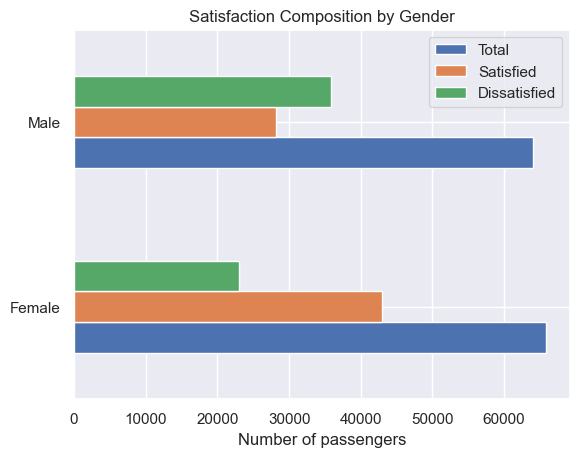

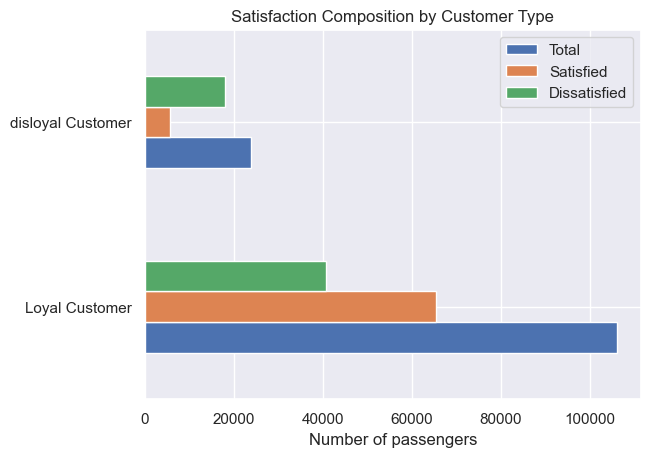

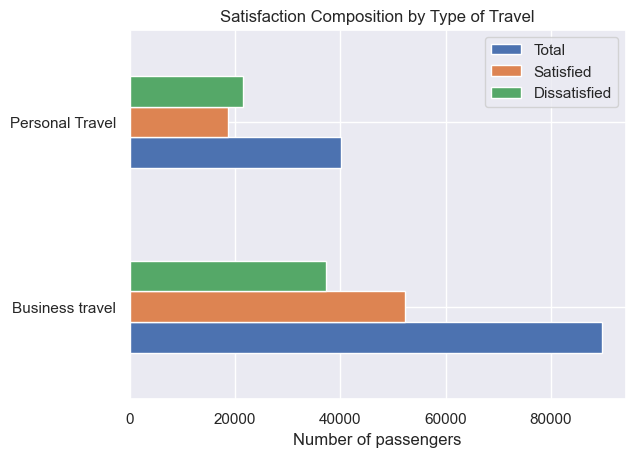

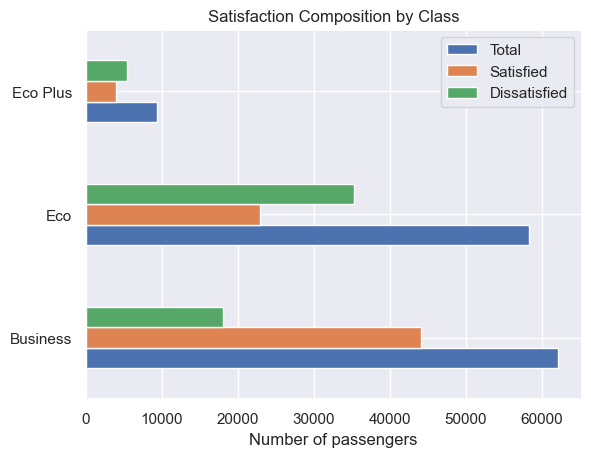

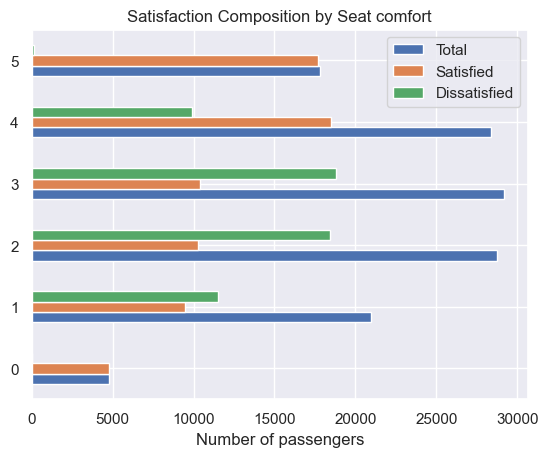

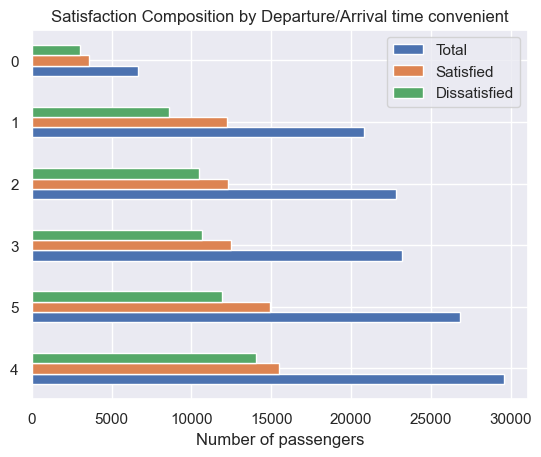

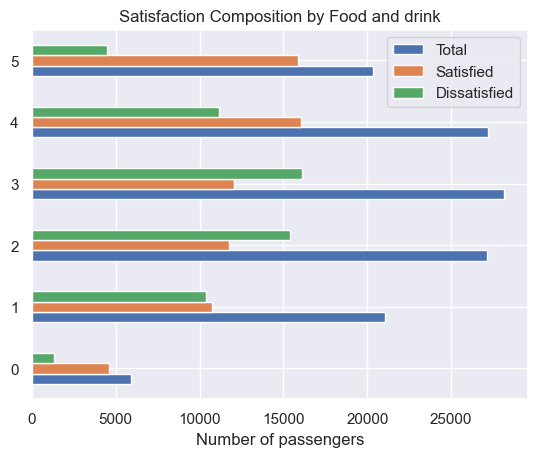

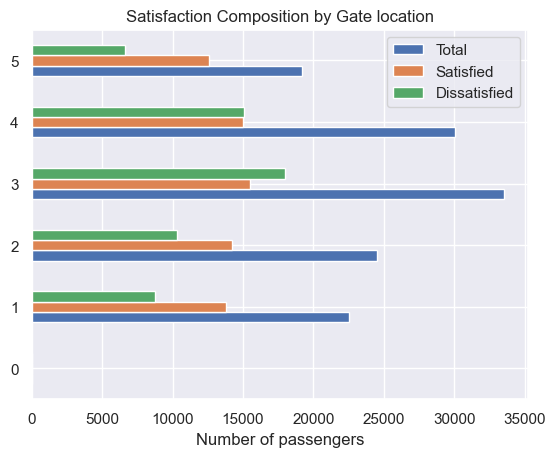

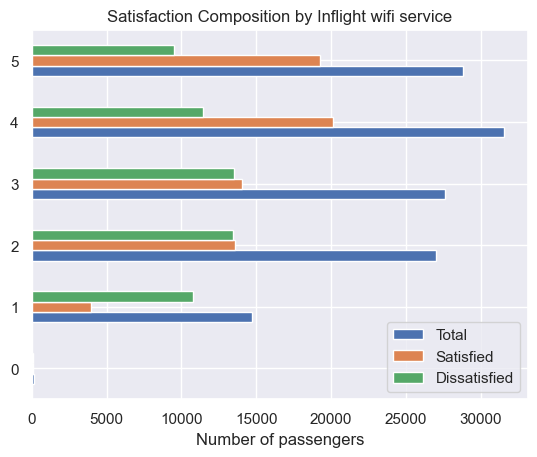

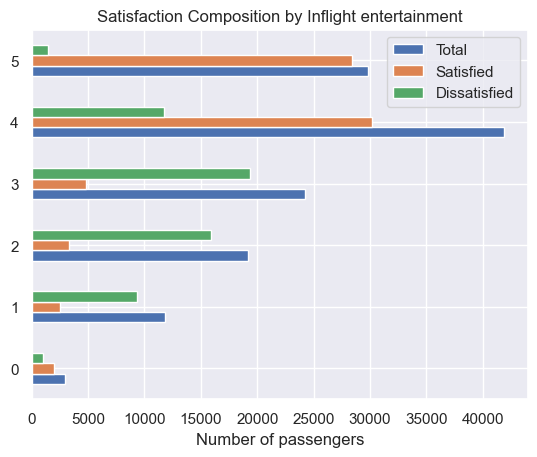

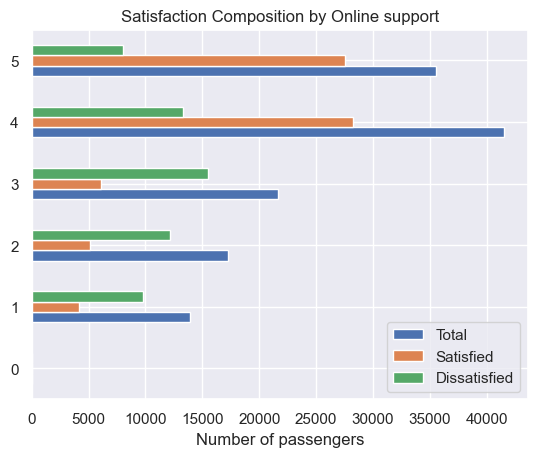

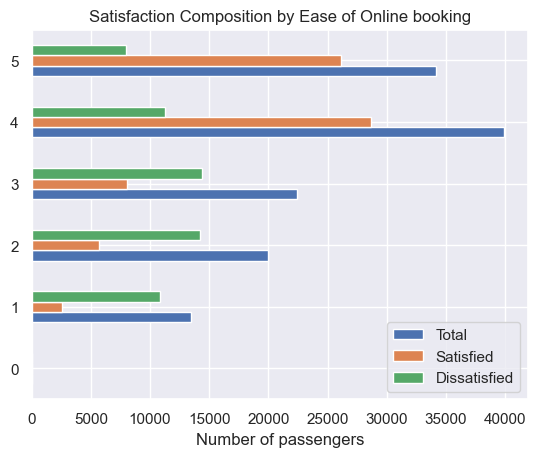

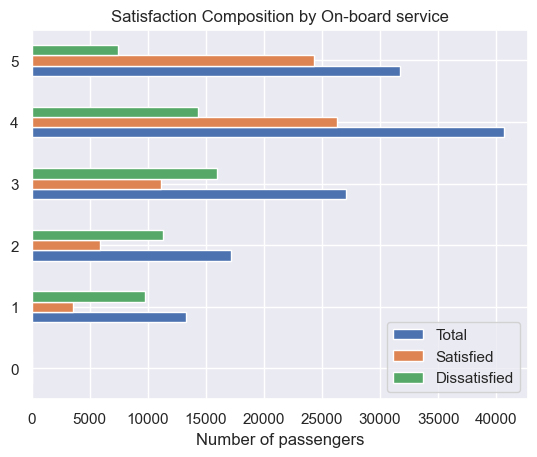

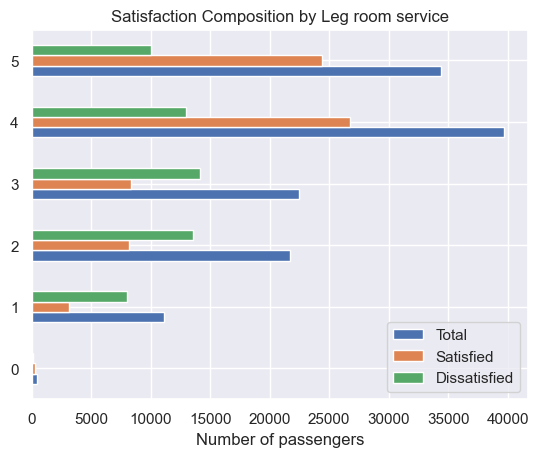

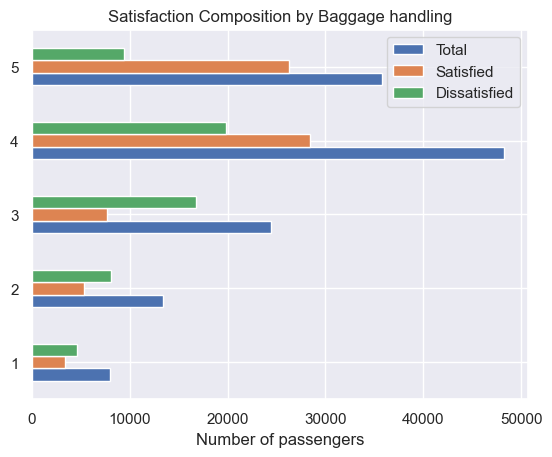

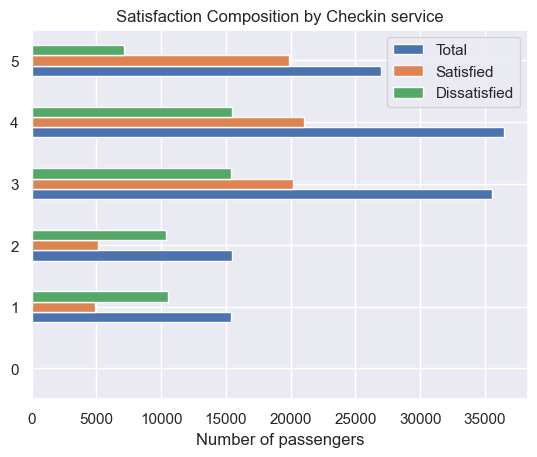

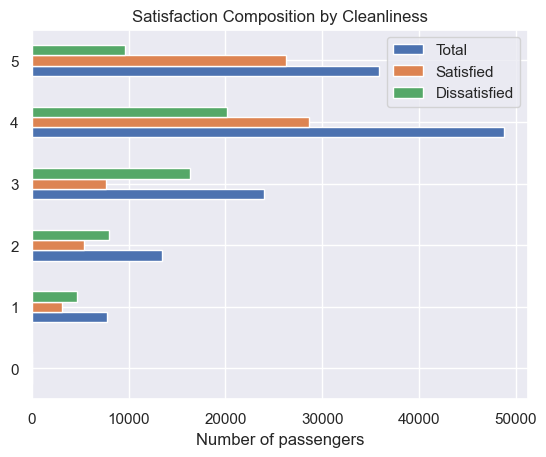

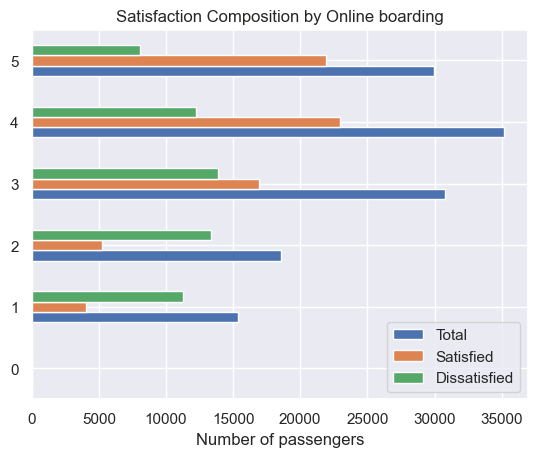

In [16]:
# obtain list of categorical feature names
noncat_feat = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
all_feat = list(data.columns)

cat_feat = [i for i in all_feat if i not in noncat_feat and i != 'satisfaction']

# iterate over each categorical feature
for index, feat in enumerate(cat_feat):
    plt.close()
    feat_tot = data[feat].value_counts()
    feat_sat = data[data['satisfaction'] == 'satisfied'][feat].value_counts()
    feat_unsat = data[data['satisfaction'] == 'dissatisfied'][feat].value_counts()

    df = pd.DataFrame({'Total': feat_tot, 'Satisfied': feat_sat, 'Dissatisfied': feat_unsat})

    df.plot.barh()
    plt.xlabel('Number of passengers')
    plt.title(f'Satisfaction Composition by {feat}')
    plt.legend()
    plt.show()


#### Obervations

1. Similar number of male and female passengers, but satisfaction rate of female passengers considerably higher than male.

2. More than double the number of business travellers than personal travellers. Personal traveller satisfaction rate considerably lower than that of business travellers - in fact, leisure travellers are more often dissatisfied than satisfied.

3. Almose five times more loyal customers than disloyal customers; disloyal customers have overwhelmingly high dissatisfaction rate, much higher than satisafctions rate. Loyal customers are significantly more satisfied than dissatisfied.

4. Comparable number of passengers in business class and economy; far fewer passengers in eco plus. Satisfaction rate drops with class; business class passengers are more frequently satisfied but economy and co plus passengers are more often dissatisfied.

5. For service rating features: the higher the rating, the greater the satisfaction rate; overall satisfaction surpasses dissatisfcations when ratings are are greater or equal to 3 or 4. Most common mode for each rating feature is 4.

### Relationship between satisfaction and numerical features

In [24]:
print(noncat_feat)

['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']


In [29]:
num_data = []

# Define the age groups
bins_age = [0, 18, 24, 34, 44, 54, 64, max(X_filled['Age'])]

labels_age = ['0-18', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']

age = {'bins': bins_age, 'categories': labels_age,
       'name': 'Age', 'units': 'Years'}

num_data.append(age)

# Define the flight distance groups
bins_dis = [min(data['Flight Distance']), 550, 1050, 1550, 2050, 2550,
            3050, 3550, 4050, max(X_filled['Flight Distance'])]

labels_dis = [f'{min(X_filled["Flight Distance"])}-550', '551-1050', '1051-1550', '1551-2050',
              '2051-2550', '2551-3050', '3051-3550', '3551-4050', '4051+']

distance = {'bins': bins_dis, 'categories': labels_dis,
            'name': 'Flight Distance', 'units': 'Miles'}

num_data.append(distance)

# Define departure delay groups
bins_dep = [0, 9, 19, 29, 59, max(X_filled['Departure Delay in Minutes'])]

labels_dep = ['0-9', '10-19', '20-29', '30-59', '60+']

departure = {'bins': bins_dep, 'categories': labels_dep,
             'name': 'Departure Delay in Minutes', 'units':'Minutes'}

num_data.append(departure)

# Define arrival delay groups - same as departure delay groups
arrival = {'bins': bins_dep, 'categories': labels_dep,
           'name': 'Arrival Delay in Minutes', 'units':'Minutes'}

num_data.append(arrival)

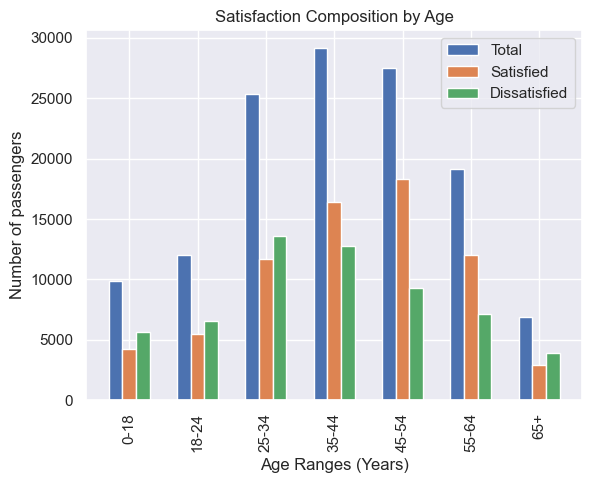

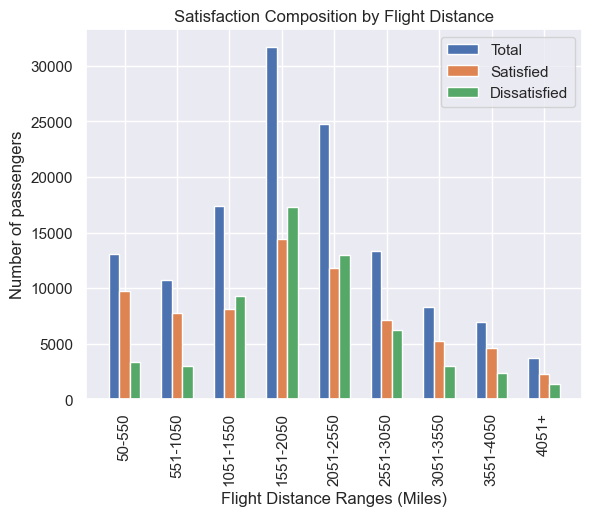

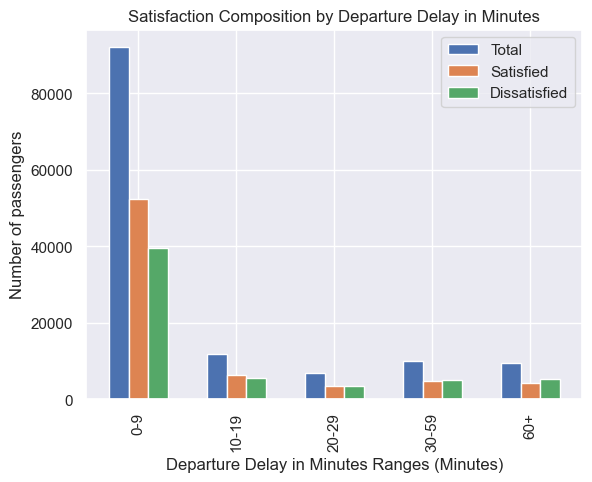

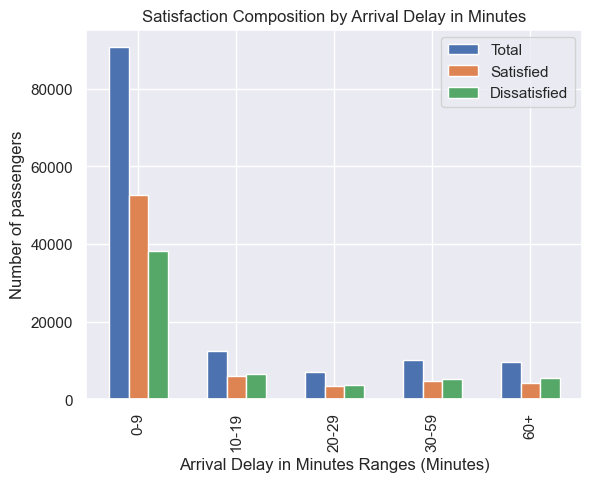

In [32]:
# iterate over all numerical data features
for feature in num_data:

    # Create a new column with the age groups
    temp = X_filled
    temp[f'{feature["name"]} Group'] = pd.cut(temp[f'{feature["name"]}'], bins=feature['bins'],
                                              labels=feature['categories'], right=False)

    # Group the DataFrame by age group and count the occurrences
    grouped = temp.groupby(f'{feature["name"]} Group').size()
    sat = temp[temp['satisfaction'] == 1].groupby(f'{feature["name"]} Group').size()
    unsat = temp[temp['satisfaction'] == 0].groupby(f'{feature["name"]} Group').size()

    # Set the positions of the bars on the x-axis
    x = np.arange(len(feature['categories']))

    # Set the width of the bars
    width = .2

    plt.close()

    # Create the figure and axes
    fig, ax = plt.subplots()

    # Plot the bars for each dataset
    ax.bar(x - width, grouped, width, label='Total')
    ax.bar(x, sat, width, label='Satisfied')
    ax.bar(x + width, unsat, width, label='Dissatisfied')

    # Set the x-axis tick positions and labels
    ax.set_xticks(x)
    ax.set_xticklabels(feature['categories'], rotation=90)

    ax.set_title(f'Satisfaction Composition by {feature["name"]}')

    # Set the y-axis label
    ax.set_ylabel('Number of passengers')
    ax.set_xlabel(f'{feature["name"]} Ranges ({feature["units"]})')

    # Add a legend
    ax.legend()

    # Show the plot
    plt.show()
    plt.close()

### Key Observations:

1. Satisfaction rate greater than 50% amongst ages 35-64; possibly because they travel in business class the most - should investigate further.

2. Dissatisfaction rate greater than 50% on flights with moderate distance travel (1051 - 2550 miles) - the most frequent distance traversed by air. For shorter or longer flight distances, satisfaction is greater than 50% - could be due to superior services on long-haul flights and/or lower expectations of passengers for short-haul flights.

3. For delays in departure/arrival, delays less than 10 minutes do not severly impact satisfaction as satisfaction rate is significantly higher than dissatisfaction; however, above 10 minutes, dissatisfaction rate overtakes satisfaction.

### Step 5: Inspect additional trends of interest

#### Relationship between passenger loyalty and class of travel

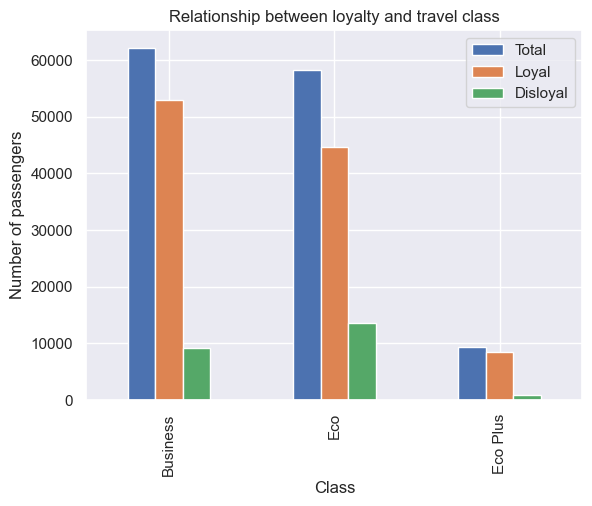

In [4]:
class_tot = data['Class'].value_counts()
class_loyal = data[data['Customer Type'] == 'Loyal Customer']['Class'].value_counts()
class_disloyal = data[data['Customer Type'] == 'disloyal Customer']['Class'].value_counts()

df = pd.DataFrame({'Total': class_tot, 'Loyal': class_loyal, 'Disloyal': class_disloyal})

bar_output(df, 'Class', 'Relationship between loyalty and travel class')

Loyalty percentage highest for eco plus and business classes; more/better schemes required for economy passengers to encourage loyalty?

#### Relationship between type of travel and class

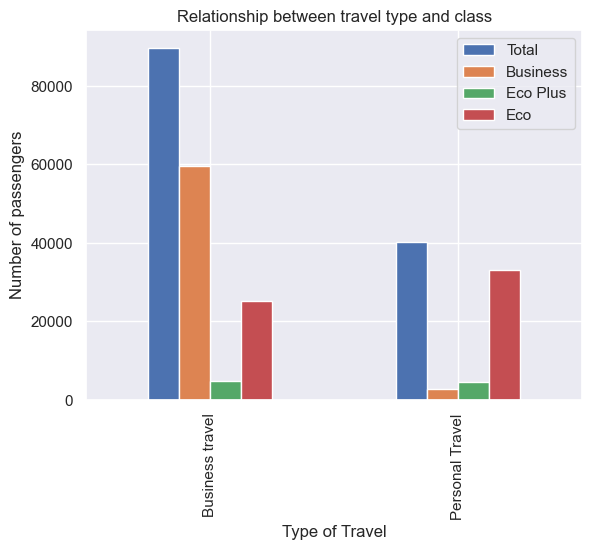

In [6]:
type_tot = data['Type of Travel'].value_counts()
type_busi = data[data['Class'] == 'Business']['Type of Travel'].value_counts()
type_ecoplus = data[data['Class'] == 'Eco Plus']['Type of Travel'].value_counts()
type_eco = data[data['Class'] == 'Eco']['Type of Travel'].value_counts()

df = pd.DataFrame({'Total': type_tot, 'Business': type_busi,
                   'Eco Plus': type_ecoplus, 'Eco': type_eco})

bar_output(df, 'Type of Travel', 'Relationship between travel type and class')

Majority of passengers travelling for business travel in business class; whereas majoirty of passengers travelling for perosnal reasons travel in economy class.

Two valid, inter-related reasons why business class satisfaction is generally higher than econonmy:

1. Business class services are superior to economy (and economy plus), although at higher cost...
2. ... however, majority of business class travellers are travelling for business reasons where their employers are presumably paying. As passengers travelling for personal reasons are presumably paying for themselves, their expectations likely higher and tolerance for below par service lower.

### EDA Remarks

Some interesting and relevant trends between passenger satisfaction and the rest of the features were established; however, predicting passenger satsifaction and subsequently revealing the most significant features are the primary aims; both of which can be most effectively attained using machine learning classifiers.

## ML Model Training

### Target feature handling

The 'satisfaction' column must be separated from the main data set into a pandas Series

In [63]:
# set positive target instance as 'dissatisfied'
X_filled['satisfaction'] = X_filled['satisfaction'].replace({0: 1, 1: 0})


In [11]:
X_filled.head()

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,0.0,0.0,0.0,65.0,1.0,1.0,265.0,0.0,0.0,0.0,...,2.0,3.0,3.0,0.0,3.0,5.0,3.0,2.0,0.0,0.0
1,0.0,1.0,0.0,47.0,1.0,0.0,2464.0,0.0,0.0,0.0,...,2.0,3.0,4.0,4.0,4.0,2.0,3.0,2.0,310.0,305.0
2,0.0,0.0,0.0,15.0,1.0,1.0,2138.0,0.0,0.0,0.0,...,2.0,2.0,3.0,3.0,4.0,4.0,4.0,2.0,0.0,0.0
3,0.0,0.0,0.0,60.0,1.0,1.0,623.0,0.0,0.0,0.0,...,3.0,1.0,1.0,0.0,1.0,4.0,1.0,3.0,0.0,0.0
4,0.0,0.0,0.0,70.0,1.0,1.0,354.0,0.0,0.0,0.0,...,4.0,2.0,2.0,0.0,2.0,4.0,2.0,5.0,0.0,0.0


In [64]:
# separate target variable from main data set
y = X_filled['satisfaction']
X_sep = X_filled.drop('satisfaction', axis=1)
X_sep.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,0.0,0.0,65.0,1.0,1.0,265.0,0.0,0.0,0.0,2.0,...,2.0,3.0,3.0,0.0,3.0,5.0,3.0,2.0,0.0,0.0
1,1.0,0.0,47.0,1.0,0.0,2464.0,0.0,0.0,0.0,3.0,...,2.0,3.0,4.0,4.0,4.0,2.0,3.0,2.0,310.0,305.0
2,0.0,0.0,15.0,1.0,1.0,2138.0,0.0,0.0,0.0,3.0,...,2.0,2.0,3.0,3.0,4.0,4.0,4.0,2.0,0.0,0.0
3,0.0,0.0,60.0,1.0,1.0,623.0,0.0,0.0,0.0,3.0,...,3.0,1.0,1.0,0.0,1.0,4.0,1.0,3.0,0.0,0.0
4,0.0,0.0,70.0,1.0,1.0,354.0,0.0,0.0,0.0,3.0,...,4.0,2.0,2.0,0.0,2.0,4.0,2.0,5.0,0.0,0.0


### Split data into training and test data

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_sep, y, test_size=.2, stratify=y)

### Examine baseline performance of ML models

In [66]:
# Define baseline model
dummy = DummyClassifier(strategy='uniform')

# Define (untuned) ML models
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
xgb_class = xgb.XGBClassifier()

models = [dummy, dtc, rfc, xgb_class]

for model in models:

    # Perform cross-validation and obtain scores
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='recall')

    print(f"{model.__class__}")
    print(f"Mean score: {scores.mean(): .5f}")
    print(f"Standard deviation: {scores.std(): .5f}")
    print('\n----------\n')


<class 'sklearn.dummy.DummyClassifier'>
Mean score:  0.50013
Standard deviation:  0.00396

----------

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
Mean score:  0.92897
Standard deviation:  0.00348

----------

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Mean score:  0.95950
Standard deviation:  0.00348

----------

<class 'xgboost.sklearn.XGBClassifier'>
Mean score:  0.95960
Standard deviation:  0.00340

----------



#### Evidently, the dummy model performs significantly worse than un-optimised ML models so there are grounds to proceed with model optimisation

### Baseline Model

In [60]:
# execute dummy classifier on training and testing data sets

dum_est = DummyClassifier(strategy='uniform')

n = score_output(dum_est, X_train, X_test, y_train, y_test)

----------
Recall

Test:  0.4966
Training:  0.4998

----------
Accuracy

Test:  0.4983
Training:  0.4992



### Random Forest Classifier

In [46]:
# Define search space for parameter tuning

bayes_params_rfc = {'max_depth': (1, 50, 'uniform'),
                   'n_estimators': (100, 400, 'uniform'),
                   'min_samples_split': (2, 100, 'uniform'),
                   'min_samples_leaf': (1, 100, 'uniform')}

In [62]:
rfc = RandomForestClassifier()
rfc_search = BayesSearchCV(rfc, bayes_params_rfc, scoring='recall',
                           n_jobs=-1, n_iter=40, cv=StratifiedKFold(5))

rfc_search.fit(X_train, y_train)

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=RandomForestClassifier(), n_iter=40, n_jobs=-1,
              scoring='recall',
              search_spaces={'max_depth': (1, 50, 'uniform'),
                             'min_samples_leaf': (1, 100, 'uniform'),
                             'min_samples_split': (2, 100, 'uniform'),
                             'n_estimators': (100, 400, 'uniform')})

In [63]:
# Display optimal estimator
rfc_search.best_estimator_

RandomForestClassifier(max_depth=50, n_estimators=400)

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Random Forest Classifier Learning Curve'}, xlabel='Training examples', ylabel='Score'>,
 'Random Forest Classifier Learning Curve')

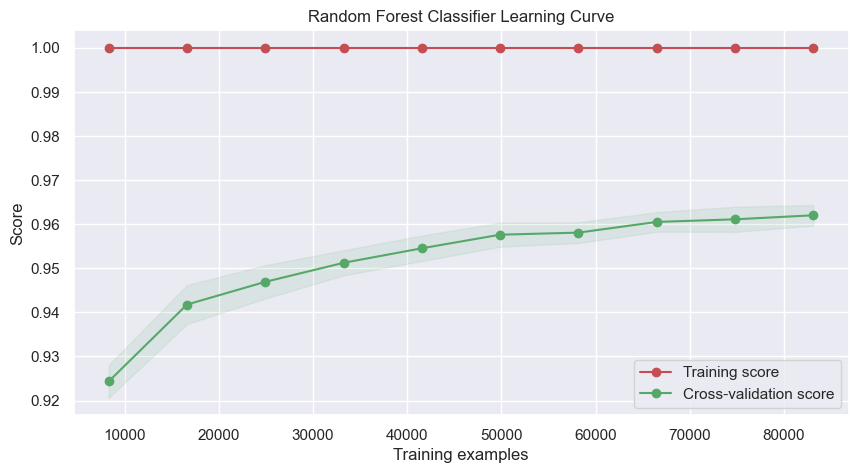

In [64]:
# Generate learning curve
plt.close()
plot_learning_curve(rfc_search.best_estimator_, X_train, y_train,
                    cv=StratifiedKFold(5), n_jobs=-1 , train_sizes=np.linspace(.1,1,10),
                    scoring='recall', title='Random Forest Classifier Learning Curve')

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': "Validation Curve with <class 'sklearn.ensemble._forest.RandomForestClassifier'>"}, xlabel='max_depth', ylabel='recall'>)

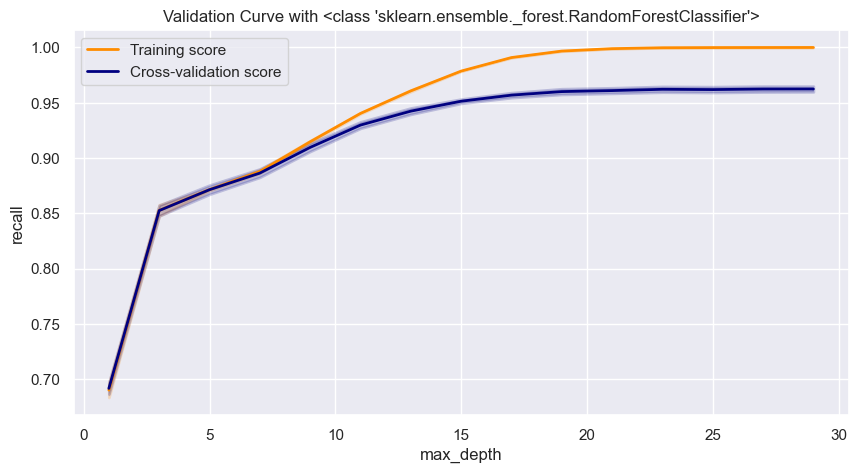

In [66]:
# Generate validation curve for max_depth parameter
plt.close()
plot_validation_curve(rfc_search.best_estimator_, X_train, y_train,
                      cv=StratifiedKFold(5), n_jobs=-1, scoring='recall',
                      param_name='max_depth', param_range=np.arange(1,30,2))

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': "Validation Curve with <class 'sklearn.ensemble._forest.RandomForestClassifier'>"}, xlabel='n_estimators', ylabel='recall'>)

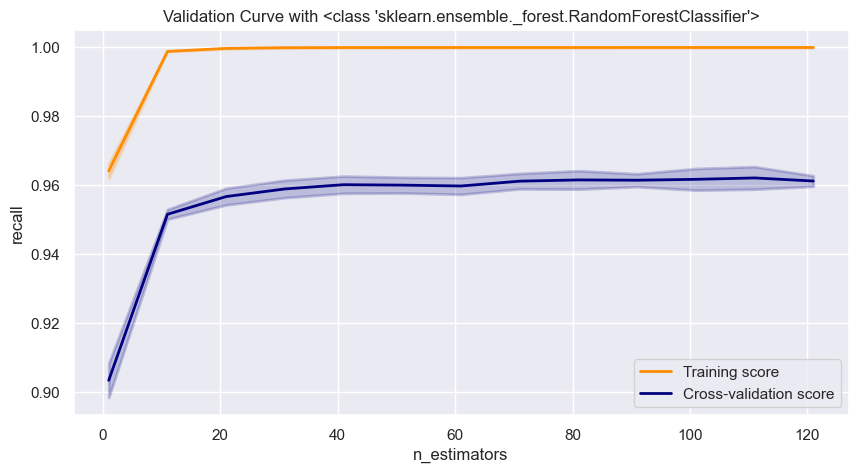

In [95]:
# Generate validation curve for n_estimators parameter
plt.close()
plot_validation_curve(rfc_search.best_estimator_, X_train, y_train,
                      cv=StratifiedKFold(5), n_jobs=-1, scoring='recall',
                      param_name='n_estimators', param_range=np.arange(1,125,10))

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': "Validation Curve with <class 'sklearn.ensemble._forest.RandomForestClassifier'>"}, xlabel='min_samples_split', ylabel='recall'>)

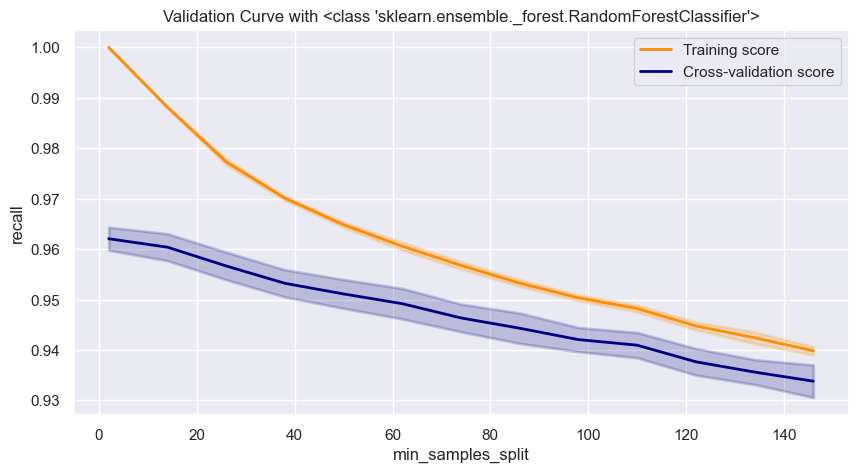

In [68]:
# Generate validation curve for min_samples_split parameter
plt.close()
plot_validation_curve(rfc_search.best_estimator_, X_train, y_train,
                      cv=StratifiedKFold(5), n_jobs=-1, scoring='recall',
                      param_name='min_samples_split', param_range=np.arange(2,150,12))


(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': "Validation Curve with <class 'sklearn.ensemble._forest.RandomForestClassifier'>"}, xlabel='min_samples_leaf', ylabel='recall'>)

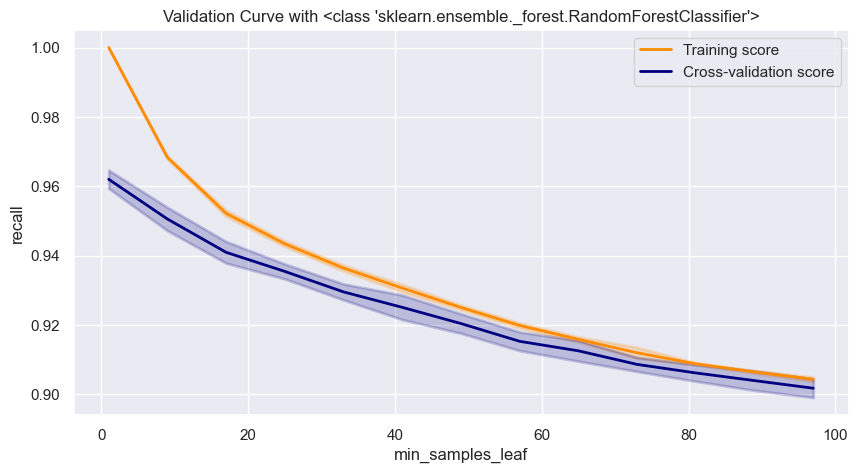

In [70]:
# Generate validation curve for min_samples_leaf parameter
plt.close()
plot_validation_curve(rfc_search.best_estimator_, X_train, y_train,
                      cv=StratifiedKFold(5), n_jobs=-1, scoring='recall',
                      param_name='min_samples_leaf', param_range=np.arange(1,100,8))


#### Observations

Learning curve - both learning data and cross-validation datasets begin to plateau as samples tends to 100,000; however, have not completely levelled off suggesting more training data can further improve model performance - or reducing dimensionality could.

max_depth validation curve - overfitting when max_depth > 12; therefore, the max_depth parameter should be set to 12.

n_estimators - plateau when n_estimators > 40; therefore, n_estimators set to 40

min_samples_split validation curve - overfitting initiates when min_samples_split < 60 - so min_samples_split should be set to 60.

min_samples_leaf validation curve - overfitting indicated when min_samples_leaf < 15 since the learning fit precision increases at a much greater rate than itself previously and the validation set precision; thus min_samples_leaf should be set to 15.

In [67]:
# Define final Random Forest Classifier object
tuned_rfc = RandomForestClassifier(max_depth=12, n_estimators=40,
                                   min_samples_split=60, min_samples_leaf=15)

pred_rfc = score_output(tuned_rfc, X_train, X_test, y_train, y_test)

----------
Recall

Test:  0.9314
Training:  0.9343

----------
Accuracy

Test:  0.9372
Training:  0.9410



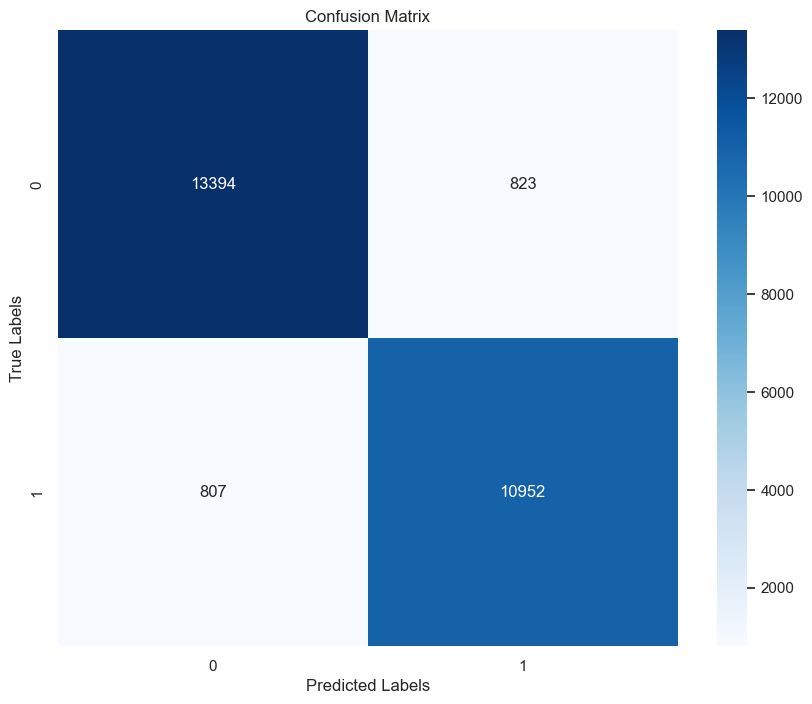

In [68]:
# Compute confusion matrix
cm = confusion_matrix(y_test, pred_rfc)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig('RFC Confusion Matrix.png')

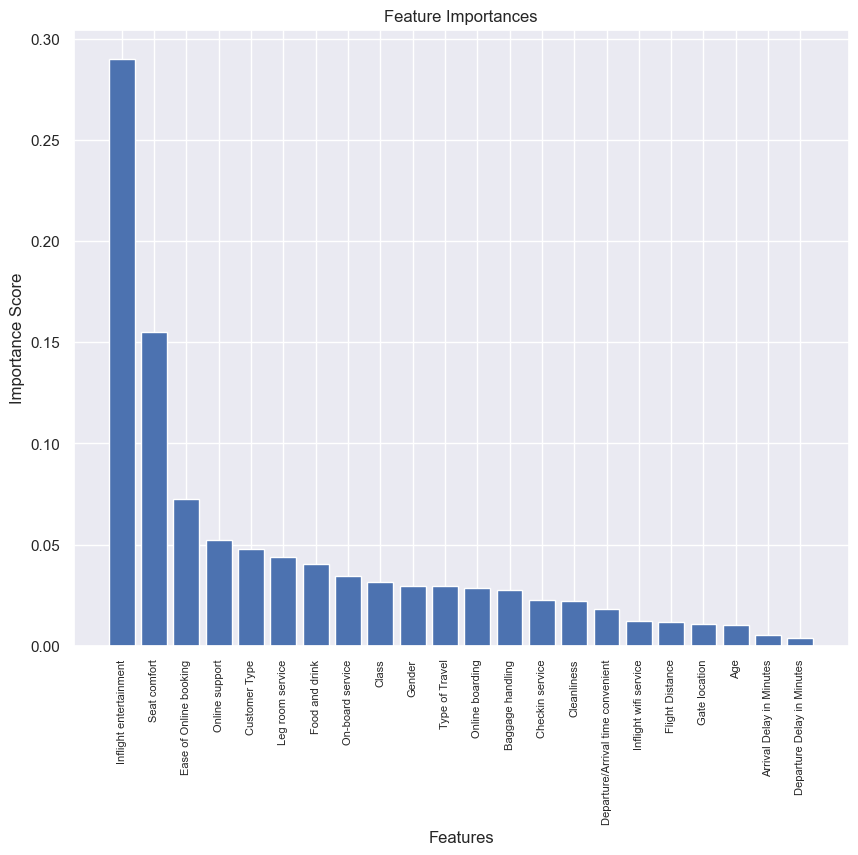

In [69]:
# Get feature importances
importances = tuned_rfc.feature_importances_

# Sort feature importances in descending order
sorted_indices = importances.argsort()[::-1]
sorted_importances = importances[sorted_indices]

# Get feature names
feature_names = X_sep.columns

# Plot feature importances
plt.close()
plt.figure(figsize=(10, 8))
plt.bar(range(X_sep.shape[1]), sorted_importances, tick_label=feature_names[sorted_indices])
plt.xticks(rotation=90, fontsize=8)
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()

#### Comment

Reasonably high recall and accuracy as well as minimal (< 0.1%) variance between metric scores for training and test sets suggests adequate fitting and effective model.

Possible that gradient boosting algorithms (e.g. Adaboost, XGBoost) obtains greater results - be investigated next!

### XGBoost Classifier

In [76]:
# Define search space for Bayesian search
bayes_params_xgb = {'max_depth': (1, 20, 'uniform'),
                   'n_estimators': (100, 400, 'uniform'),
                   'learning_rate': (.01, .3, 'uniform'),
                   'subsample': (.1, 1., 'uniform'),
                   }

In [77]:
# execute Bayesian Search for optimised model
xgb_class = xgb.XGBClassifier()
xgb_search = BayesSearchCV(xgb_class, bayes_params_xgb, scoring='recall',
                           n_jobs=-1, n_iter=40, cv=StratifiedKFold(5))

xgb_search.fit(X_train, y_train)

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, gpu_id=None, grow_policy=None,
                                      importance...
                                      max_leaves=None, min_child_weight=None,
                                      missing=nan, monotone_constraints=None,
                                      n_estimators=100, n_jobs=None,
                                      num_parallel_tree=None, predictor=None,
                                      random_state=None, ...),
              n_iter=40, n_jobs=-1, scoring='recall',
              search_spaces={'learning_rate': (0.01, 0.3, 'uniform'),
                             'max_depth': (1, 20, 'uniform'),
                             'n_estimators': (100, 400, 'uniform'),
                             'subsample': (0.1, 1.0, 'uniform')})

In [78]:
xgb_search.best_params_

OrderedDict([('learning_rate', 0.06310427707253037),
             ('max_depth', 15),
             ('n_estimators', 187),
             ('subsample', 1.0)])

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'XGBClassifier Learning Curve'}, xlabel='Training examples', ylabel='Score'>,
 'XGBClassifier Learning Curve')

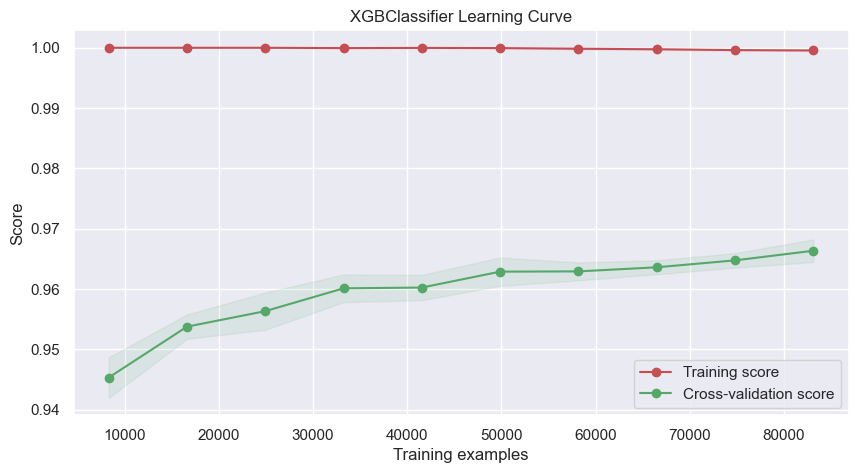

In [82]:
plt.close()

# Generate learning curve
plot_learning_curve(xgb_search.best_estimator_, X_train, y_train,
                    cv=StratifiedKFold(5), n_jobs=-1 , train_sizes=np.linspace(.1,1,10),
                    scoring='recall', title='XGBClassifier Learning Curve')

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': "Validation Curve with <class 'xgboost.sklearn.XGBClassifier'>"}, xlabel='max_depth', ylabel='recall'>)

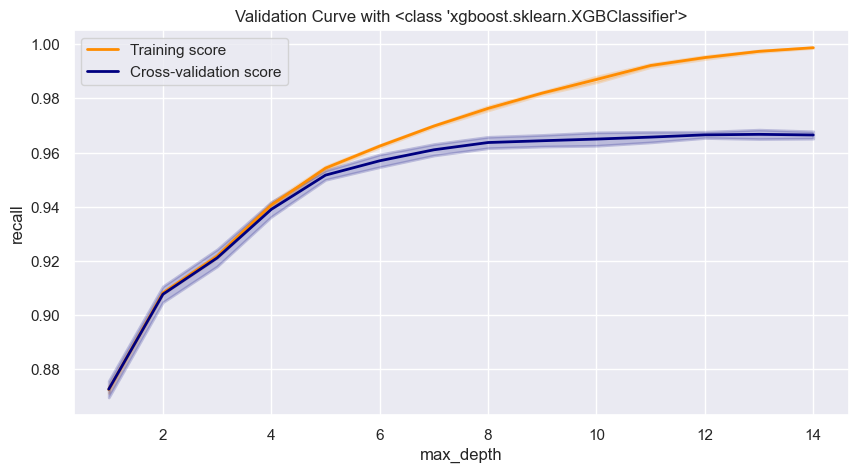

In [83]:
plt.close()

# Generate validation curve for max_depth parameter
plot_validation_curve(xgb_search.best_estimator_, X_train, y_train,
                      cv=StratifiedKFold(5), n_jobs=-1, scoring='recall',
                      param_name='max_depth', param_range=np.arange(1,15,1))

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': "Validation Curve with <class 'xgboost.sklearn.XGBClassifier'>"}, xlabel='n_estimators', ylabel='recall'>)

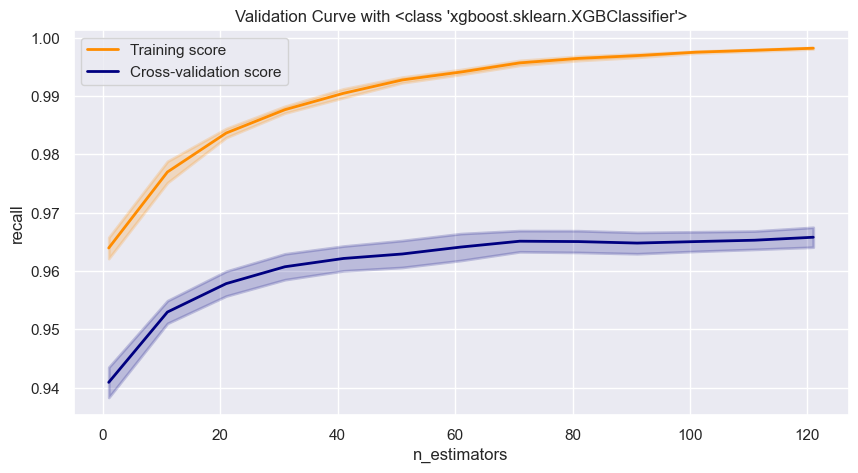

In [90]:
plt.close()

# Generate validation curve for n_estimators parameter
plot_validation_curve(xgb_search.best_estimator_, X_train, y_train,
                      cv=StratifiedKFold(5), n_jobs=-1, scoring='recall',
                      param_name='n_estimators', param_range=np.arange(1, 125, 10))

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': "Validation Curve with <class 'xgboost.sklearn.XGBClassifier'>"}, xlabel='learning_rate', ylabel='recall'>)

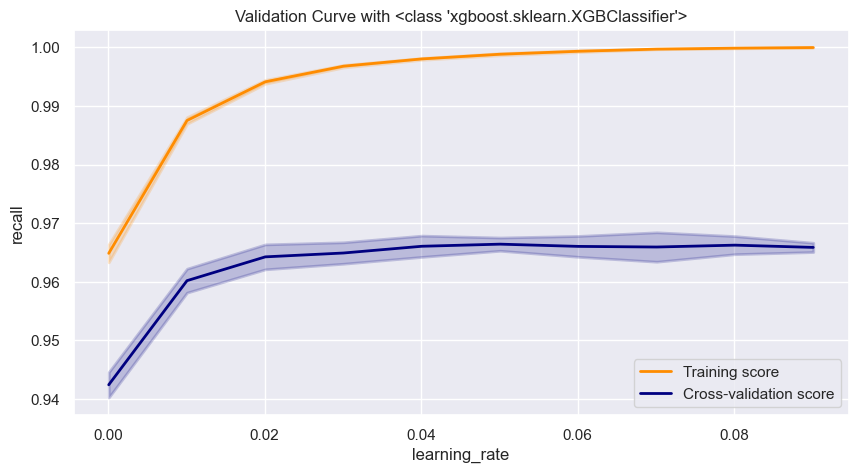

In [93]:
plt.close()

# Generate validation curve for learning_rate parameter
plot_validation_curve(xgb_search.best_estimator_, X_train, y_train,
                      cv=StratifiedKFold(5), n_jobs=-1, scoring='recall',
                      param_name='learning_rate', param_range=np.arange(.0001, .1, .01))

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': "Validation Curve with <class 'xgboost.sklearn.XGBClassifier'>"}, xlabel='subsample', ylabel='recall'>)

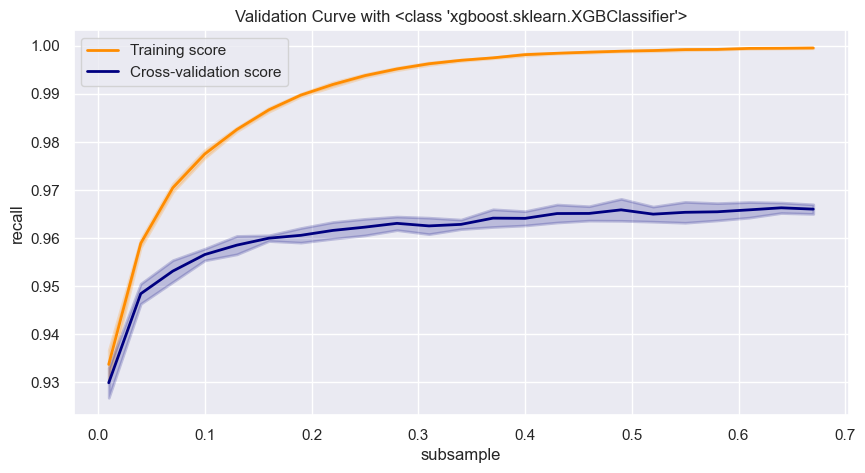

In [88]:
plt.close()

# Generate validation curve for subsample parameter
plot_validation_curve(xgb_search.best_estimator_, X_train, y_train,
                      cv=StratifiedKFold(5), n_jobs=-1, scoring='recall',
                      param_name='subsample', param_range=np.arange(.01, .7, .03))

#### Observations

Learning curve - cross-validation score plateaus, but not fully - more data would aid quality. Training score remians at 1; sign of over-fitting to be corrected by hyper-parameter adjustment.

max_depth validation curve - overfitting starts when max_depth > 9 and cross-validation precision begins to plateau so max_depth should be set to 9.

n_estimators - plateau when n_estimators > 70; so n_estimators should be set to 70

learning_rate validation curve - over-fitting when learning_rate > 0.02 so learning_rate should be set to 0.02.

subsample - overfitting when subsample > 0.075 - so subsample should be set to 0.075.

In [70]:
# optimal XGBClassifier

tuned_xgb = xgb.XGBClassifier(max_depth=9, n_estimators=70,
                              learning_rate=.02, subsample=.075)

pred_xgb = score_output(tuned_xgb, X_train, X_test, y_train, y_test)

----------
Recall

Test:  0.9328
Training:  0.9347

----------
Accuracy

Test:  0.9389
Training:  0.9407



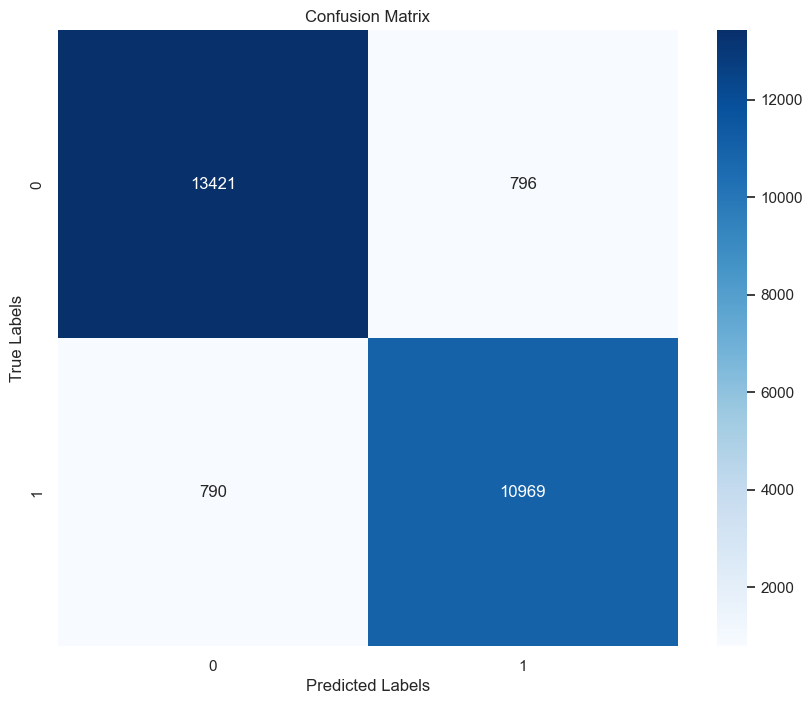

In [71]:
# Compute confusion matrix
cm = confusion_matrix(y_test, pred_xgb)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig('XGB Confusion Matrix.png')

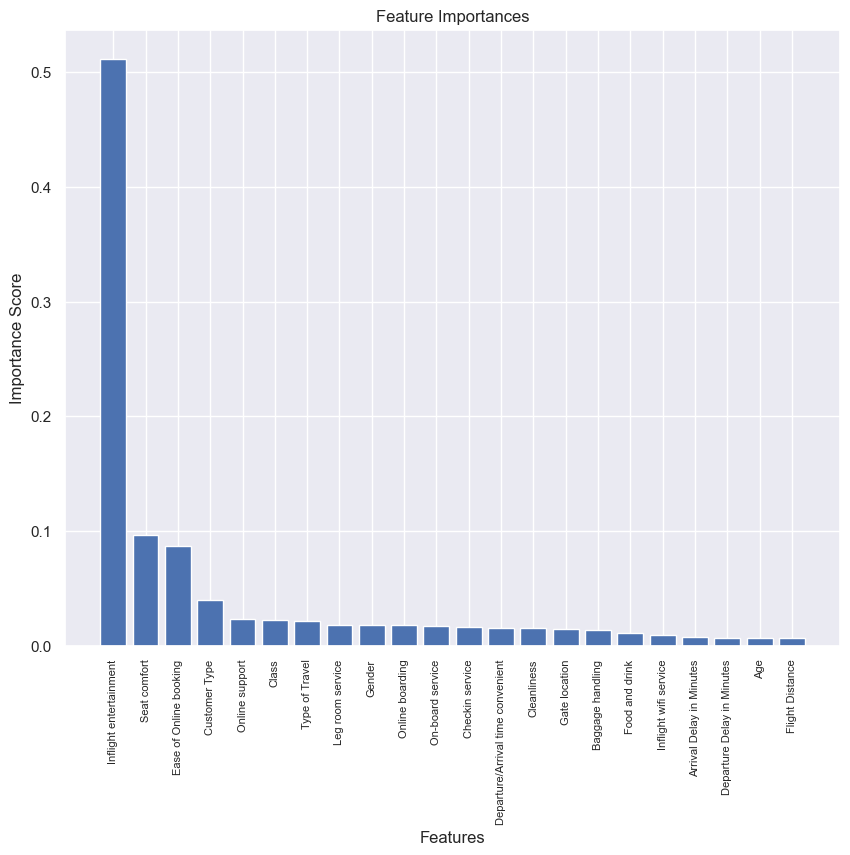

In [72]:
# Get feature importances
importances = tuned_xgb.feature_importances_

# Sort feature importances in descending order
sorted_indices = importances.argsort()[::-1]
sorted_importances = importances[sorted_indices]

# Get feature names
feature_names = X_sep.columns

# Plot feature importances
plt.close()
plt.figure(figsize=(10, 8))
plt.bar(range(X_sep.shape[1]), sorted_importances, tick_label=feature_names[sorted_indices])
plt.xticks(rotation=90, fontsize=8)
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()

### Average feature importances

Due to differences in their algorithms, the models have slightly different importance values for each value but generally the rankings are the same. An overall feature importtance chart can be devised by averaging importances scores across both models.

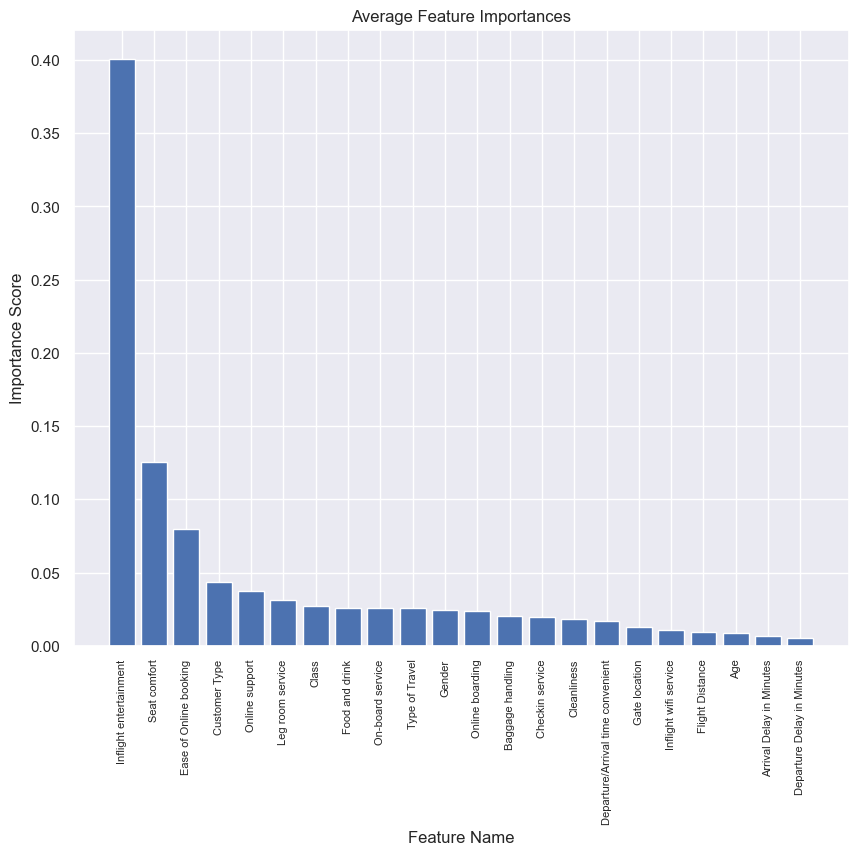

In [73]:
# Calculate average importance of each feature
avg_feat_imp = np.mean([tuned_rfc.feature_importances_, tuned_xgb.feature_importances_], axis=0)

# Sort feature importances in descending order
sorted_indices = avg_feat_imp.argsort()[::-1]
sorted_importances = avg_feat_imp[sorted_indices]

feature_names = X_sep.columns

# Plot feature importances
plt.close()
plt.figure(figsize=(10, 8))
plt.bar(range(X_sep.shape[1]), sorted_importances, tick_label=feature_names[sorted_indices])
plt.xticks(rotation=90, fontsize=8)
plt.title("Average Feature Importances")
plt.xlabel("Feature Name")
plt.ylabel("Importance Score")
plt.show()

## Conclusions

1. The most significant aspects of airline service are inflight entertainment quality, seat comfort, and ease of online booking - verified by feature_importances of both models.

2. The models performed well (~ 93% recall score) and almost identically (less than 0.02% difference in recall scores on the test data sets); although, the Random Forest Classifier had marginally superior performance.